In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from pmdarima import auto_arima
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


Data Exploration

In [112]:
df=pd.read_csv(r"C:\Users\chinm\Downloads\Call_Center_Data.csv")

df.head()

,Index,Incoming Calls,Answered Calls,Answer Rate,Abandoned Calls,ASA,AHT,CWT,Service Level (20 Seconds)
0,01-01-2021,217,204,94.01%,13,00:00:17,00:02:14,00:02:45,76.28%
1,02-01-2021,200,182,91.00%,18,00:00:20,00:02:22,00:06:55,72.73%
2,03-01-2021,216,198,91.67%,18,00:00:18,00:02:38,00:03:50,74.30%
3,04-01-2021,155,145,93.55%,10,00:00:15,00:02:29,00:03:12,79.61%
4,05-01-2021,37,37,100.00%,0,00:00:03,00:02:06,00:00:35,97.30%


In [113]:
df.shape

(1251, 9)

In [114]:
df.columns


Index(['Index', 'Incoming Calls', 'Answered Calls', 'Answer Rate',
       'Abandoned Calls', 'ASA', 'AHT', 'CWT', 'Service Level (20 Seconds)'],
      dtype='object')

In [115]:
df = df.rename(columns={'Index': 'date'})
df.columns

Index(['date', 'Incoming Calls', 'Answered Calls', 'Answer Rate',
       'Abandoned Calls', 'ASA', 'AHT', 'CWT', 'Service Level (20 Seconds)'],
      dtype='object')

In [116]:
df.isna().sum()

date                          0
Incoming Calls                0
Answered Calls                0
Answer Rate                   0
Abandoned Calls               0
ASA                           0
AHT                           0
CWT                           0
Service Level (20 Seconds)    0
dtype: int64

In [117]:
#Checking and fixing Datatypes

df.dtypes
# Date
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

# Percentage column
df['Answer Rate'] = (
    df['Answer Rate']
      .astype(str)
      .str.replace('%', '')
      .astype(float)
)

df['Service Level (20 Seconds)'] = (
    df['Service Level (20 Seconds)']
      .astype(str)
      .str.replace('%', '')
      .astype(float)
)

df['ASA'] = pd.to_timedelta(df['ASA'], errors='coerce').dt.total_seconds()
df['AHT'] = pd.to_timedelta(df['AHT'], errors='coerce').dt.total_seconds()
df['CWT'] = pd.to_timedelta(df['CWT'], errors='coerce').dt.total_seconds()

# Make sure numeric columns are numeric
cols = ['Incoming Calls', 'Abandoned Calls']
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')


df.isna().sum()

date                          0
Incoming Calls                0
Answered Calls                0
Answer Rate                   0
Abandoned Calls               0
ASA                           0
AHT                           0
CWT                           0
Service Level (20 Seconds)    0
dtype: int64

Converting Data to month and yearwise to capture trends

In [118]:
df_monthly = (
    df.set_index('date')
      .resample('ME')
      .agg({
          'Incoming Calls': 'sum',
          'Answer Rate': 'mean',
          'Abandoned Calls': 'sum',
          'ASA':'mean',
          'AHT':'mean',
          'CWT':'mean',
          'Service Level (20 Seconds)': 'mean'
      })
      .reset_index()
    .round(2)
)



In [119]:
df_monthly.head()

,date,Incoming Calls,Answer Rate,Abandoned Calls,ASA,AHT,CWT,Service Level (20 Seconds)
0,2021-01-31,5805,94.69,337,14.13,132.90,207.77,81.48
1,2021-02-28,5372,97.33,150,12.54,140.32,165.36,85.36
2,2021-03-31,4418,96.59,127,10.97,129.06,129.00,86.42
3,2021-04-30,4785,97.84,105,10.83,131.27,100.10,87.64
4,2021-05-31,5379,97.31,135,14.65,135.45,115.10,83.02


Explore trends or Data visualization

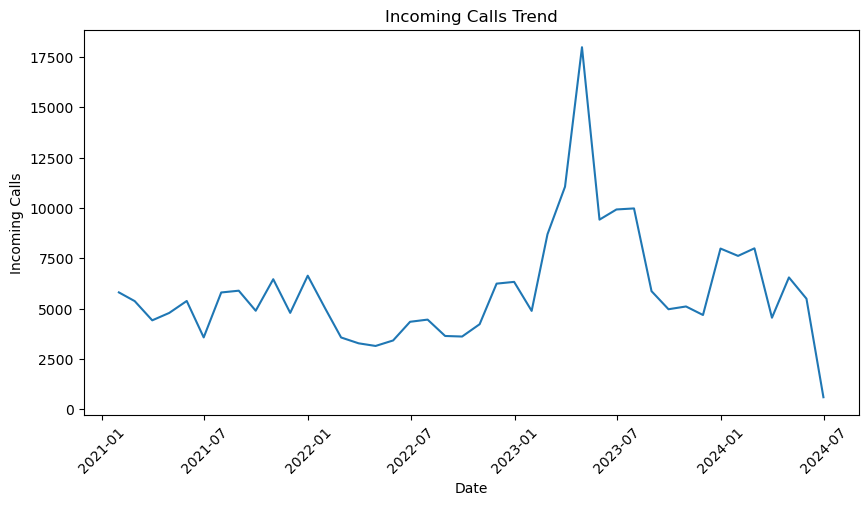

In [120]:
#Overall Call Volume Trend

plt.figure(figsize=(10,5))
plt.plot(df_monthly['date'], df_monthly['Incoming Calls'])
plt.title("Incoming Calls Trend")
plt.xlabel("Date")
plt.ylabel("Incoming Calls")
plt.xticks(rotation=45)
plt.show()


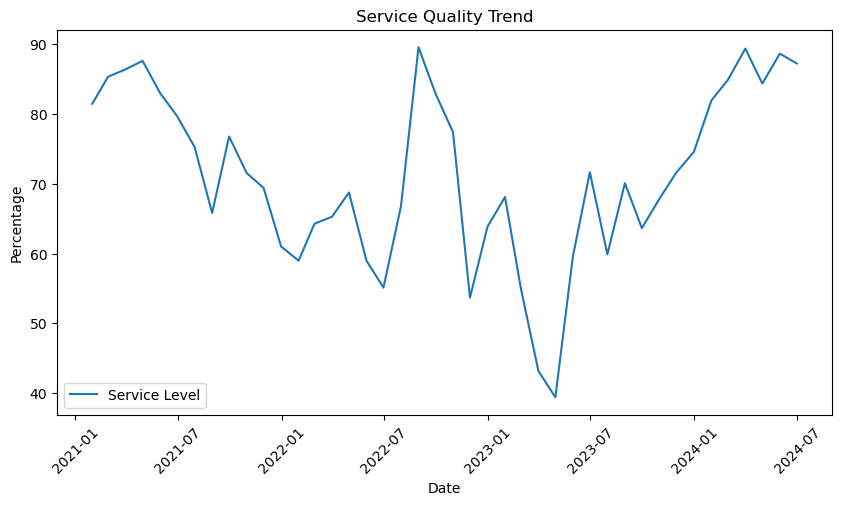

In [121]:
#Service Quality Over Time
plt.figure(figsize=(10,5))
plt.plot(df_monthly['date'], df_monthly['Service Level (20 Seconds)'], label='Service Level')
plt.legend()
plt.title("Service Quality Trend")
plt.xlabel("Date")
plt.ylabel("Percentage")
plt.xticks(rotation=45)
plt.show()


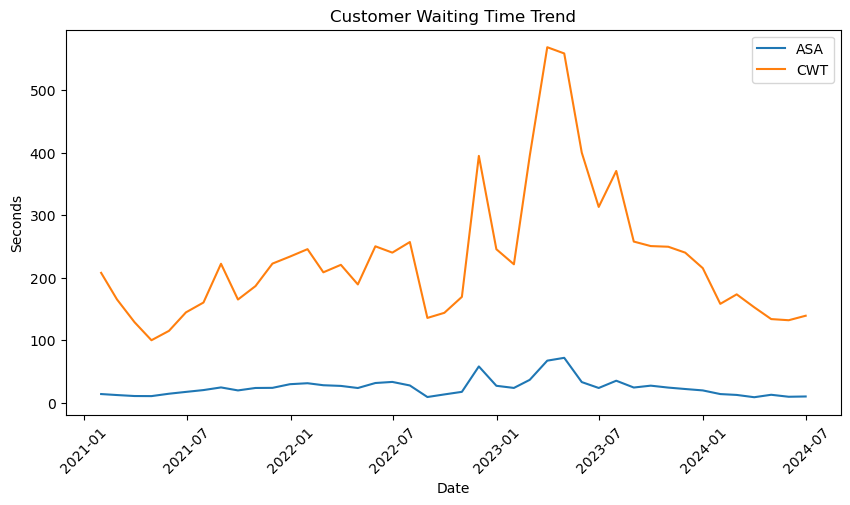

In [122]:
#Customer Experience Metrics
plt.figure(figsize=(10,5))
plt.plot(df_monthly['date'], df_monthly['ASA'], label='ASA')
plt.plot(df_monthly['date'], df_monthly['CWT'], label='CWT')
plt.legend()
plt.title("Customer Waiting Time Trend")
plt.xlabel("Date")
plt.ylabel("Seconds")
plt.xticks(rotation=45)
plt.show()


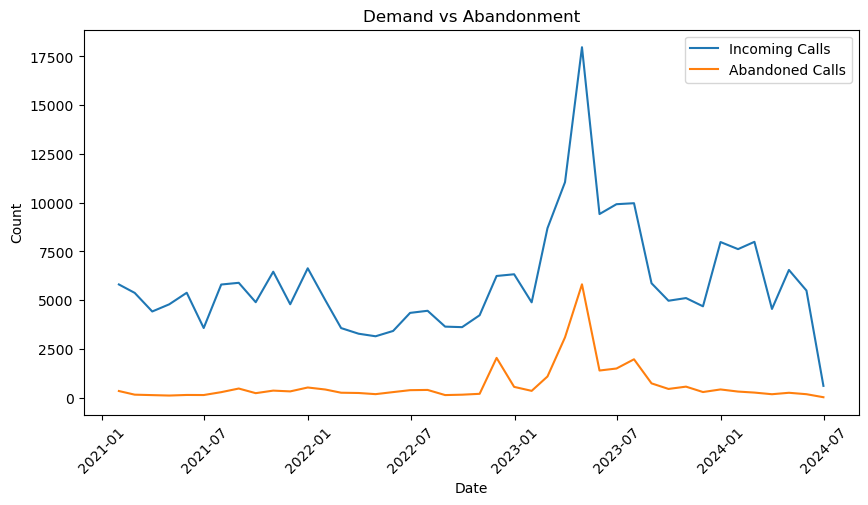

In [123]:
#Abandonment vs Volume
plt.figure(figsize=(10,5))
plt.plot(df_monthly['date'], df_monthly['Incoming Calls'], label='Incoming Calls')
plt.plot(df_monthly['date'], df_monthly['Abandoned Calls'], label='Abandoned Calls')
plt.legend()
plt.title("Demand vs Abandonment")
plt.xlabel("Date")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


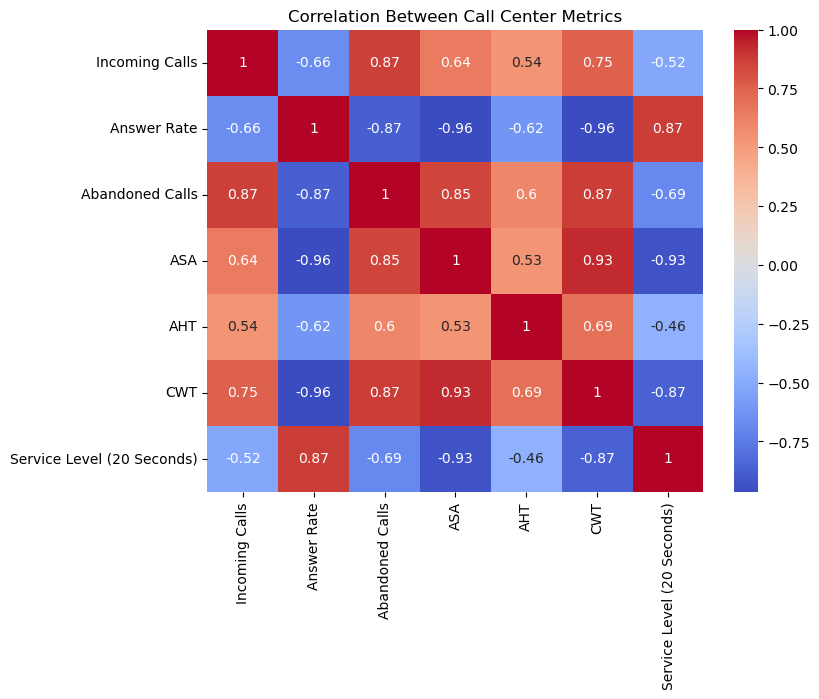

In [124]:
#Correlation Heatmap


plt.figure(figsize=(8,6))
sns.heatmap(df_monthly.drop(columns='date').corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Call Center Metrics")
plt.show()


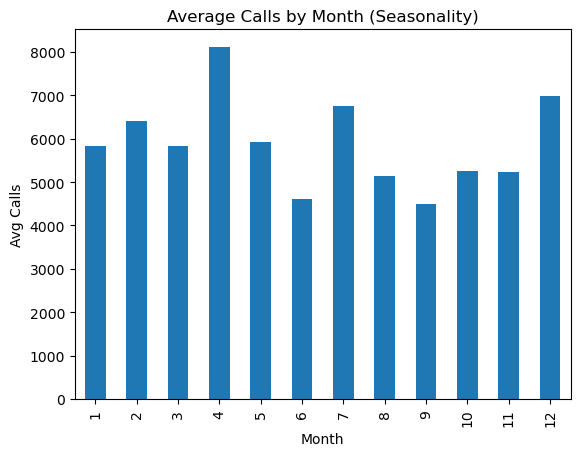

In [125]:
#Seasonality
df_monthly['Month'] = df_monthly['date'].dt.month

df_monthly.groupby('Month')['Incoming Calls'].mean().plot(kind='bar')
plt.title("Average Calls by Month (Seasonality)")
plt.xlabel("Month")
plt.ylabel("Avg Calls")
plt.show()


Forecast

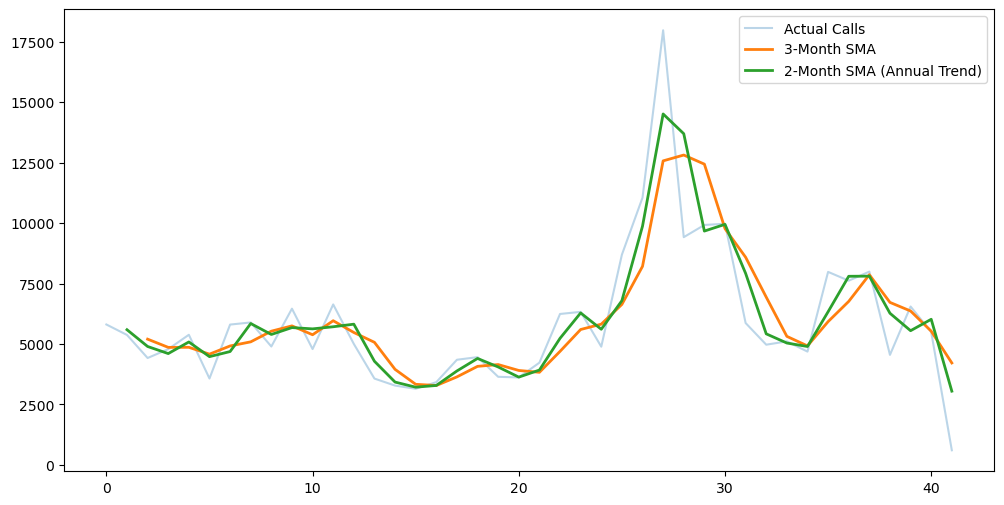

In [126]:
#Moving Average Method

# Calculate a 3-month moving average to see short-term trends
df_monthly['SMA_3'] = df_monthly['Incoming Calls'].rolling(window=3).mean()

# Calculate a 12-month moving average to see the yearly trend (removes seasonality)
df_monthly['SMA_2'] = df_monthly['Incoming Calls'].rolling(window=2).mean()

# Plotting the results
plt.figure(figsize=(12,6))
plt.plot(df_monthly.index, df_monthly['Incoming Calls'], label='Actual Calls', alpha=0.3)
plt.plot(df_monthly.index, df_monthly['SMA_3'], label='3-Month SMA', linewidth=2)
plt.plot(df_monthly.index, df_monthly['SMA_2'], label='2-Month SMA (Annual Trend)', linewidth=2)
plt.legend()
plt.show()

In [127]:
if df_monthly.index.name != 'date':
    df_monthly.set_index('date', inplace=True)

# 2. Slice the data for period (Jan-Apr 2024)
# Using a subset
subset_2024 = df_monthly.loc['2024-01-01':'2024-06-04'].copy()

 #Remove any NaN values that might exist SMA column
subset_2024.dropna(subset=['SMA_3'], inplace=True)

# 4. Extract aligned actuals and predictions
y_true = subset_2024['Incoming Calls']
y_pred = subset_2024['SMA_3']

# 5. Calculate Metrics
mse_sma = mean_squared_error(y_true, y_pred)
rmse_sma = np.sqrt(mse_sma)
print(f"SMA Mean Squared Error (MSE): {mse_sma:.2f}")
print(f"SMA Root Mean Squared Error (RMSE): {rmse_sma:.2f}")

#From MSE and RMSE we can see this forecast is not ideal let's try other methods

SMA Mean Squared Error (MSE): 1099883.22
SMA Root Mean Squared Error (RMSE): 1048.75


In [136]:
#Intialiaze the data
train = df_monthly.loc[:'2023-12-31', 'Incoming Calls']
test  = df_monthly.loc['2024-01-31':'2024-06-30', 'Incoming Calls']
result = adfuller(train)
print("ADF p-value:", result[1])
#since p-value is <0.5 we take d=0

ADF p-value: 0.09366713192887166


In [137]:
model = ARIMA(train, order=(1,0,0))
model_fit = model.fit()
#Forecast prediction
forecast = model_fit.forecast(steps=len(test))
#Save the prediction
y_pred_arima = pd.Series(forecast, index=test.index)

mse_arima = mean_squared_error(test_arima, forecast)
rmse_arima = np.sqrt(mse_arima)

print("ARIMA RMSE:", rmse_arima)
#ARIMA model is also showing high ariation moving to next Forecast methods

ARIMA RMSE: 2462.472003367856


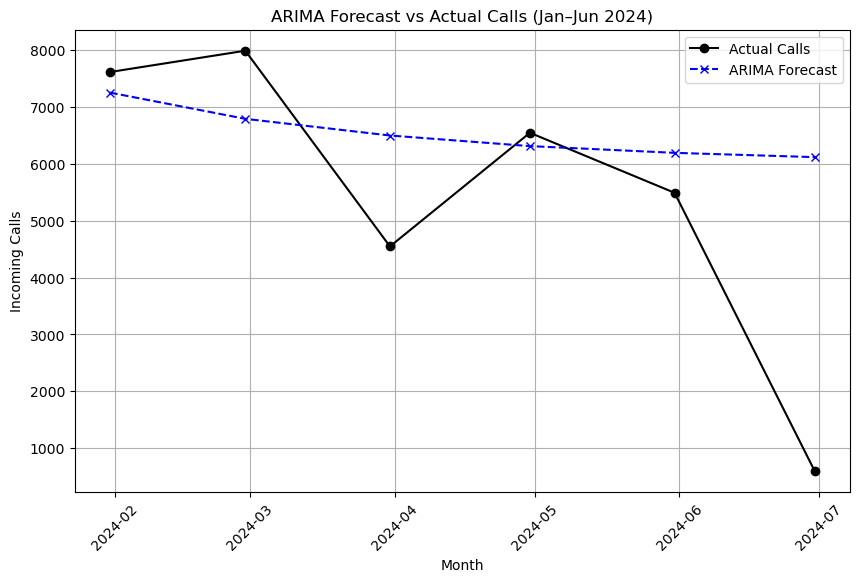

In [138]:
plt.figure(figsize=(10,6))

# Actual calls
plt.plot(test.index, test, label='Actual Calls', marker='o', color='black')

# ARIMA forecast
plt.plot(y_pred_arima.index, y_pred_arima, label='ARIMA Forecast', marker='x', linestyle='--', color='blue')

plt.title('ARIMA Forecast vs Actual Calls (Jan–Jun 2024)')
plt.xlabel('Month')
plt.ylabel('Incoming Calls')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


In [140]:
#SARIMA method of forecast

model = SARIMAX(
    train,
    order=(1,0,0),
    seasonal_order=(0,0,0,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

model_fit = model.fit()\
#forecast SARIMA 
forecast = model_fit.forecast(steps=len(test))
#save the forecast
y_pred_sarima = pd.Series(forecast, index=test.index)
mse_sarima = mean_squared_error(test, forecast)
rmse_sarima = np.sqrt(mse_sarima)

print("SARIMA RMSE:", rmse_sarima)

SARIMA RMSE: 2267.1214078693024


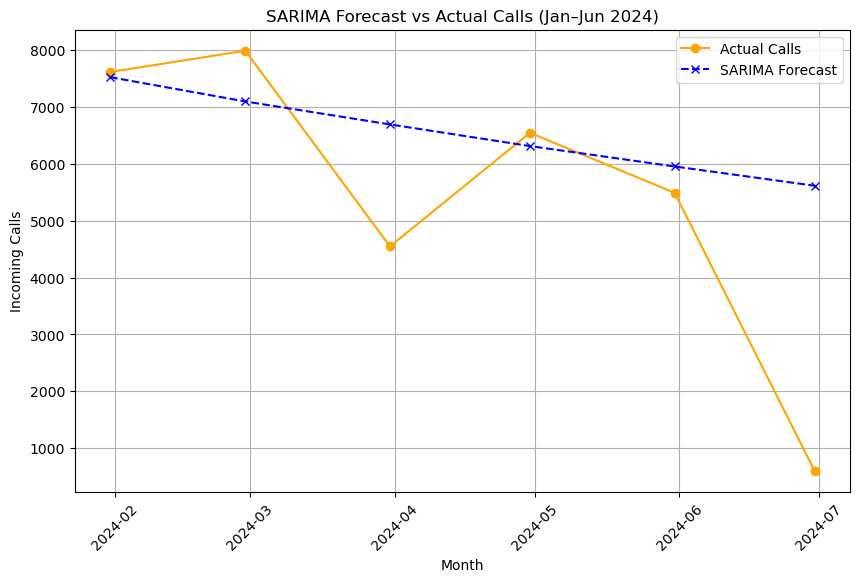

In [143]:
plt.figure(figsize=(10,6))

# Actual calls
plt.plot(test.index, test, label='Actual Calls', marker='o', color='orange')

# ARIMA forecast
plt.plot(y_pred_arima.index, y_pred_sarima, label='SARIMA Forecast', marker='x', linestyle='--', color='blue')

plt.title('SARIMA Forecast vs Actual Calls (Jan–Jun 2024)')
plt.xlabel('Month')
plt.ylabel('Incoming Calls')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [144]:
#Prophet

df_prophet = df_monthly.reset_index()[['date', 'Incoming Calls']]
df_prophet.columns = ['ds', 'y']
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

# --- Train / Test Split ---
train = df_prophet[df_prophet['ds'] <= '2023-12-31']
test  = df_prophet[(df_prophet['ds'] >= '2024-01-01') & (df_prophet['ds'] <= '2024-06-30')]

# --- Fit Prophet model ---
model = Prophet(
    yearly_seasonality=True,  # since your data is monthly
    weekly_seasonality=False,
    daily_seasonality=False
)

model.fit(train)

# --- Forecast ---
future = model.make_future_dataframe(periods=len(test), freq='M')
forecast = model.predict(future)

# --- Extract predictions for test period ---
forecast_test = forecast.tail(len(test))
y_true = test['y'].values
y_pred = forecast_test['yhat'].values

# --- Evaluate ---
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print("Prophet RMSE:", rmse)

16:21:32 - cmdstanpy - INFO - Chain [1] start processing
16:21:33 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE: 4955.019061033529


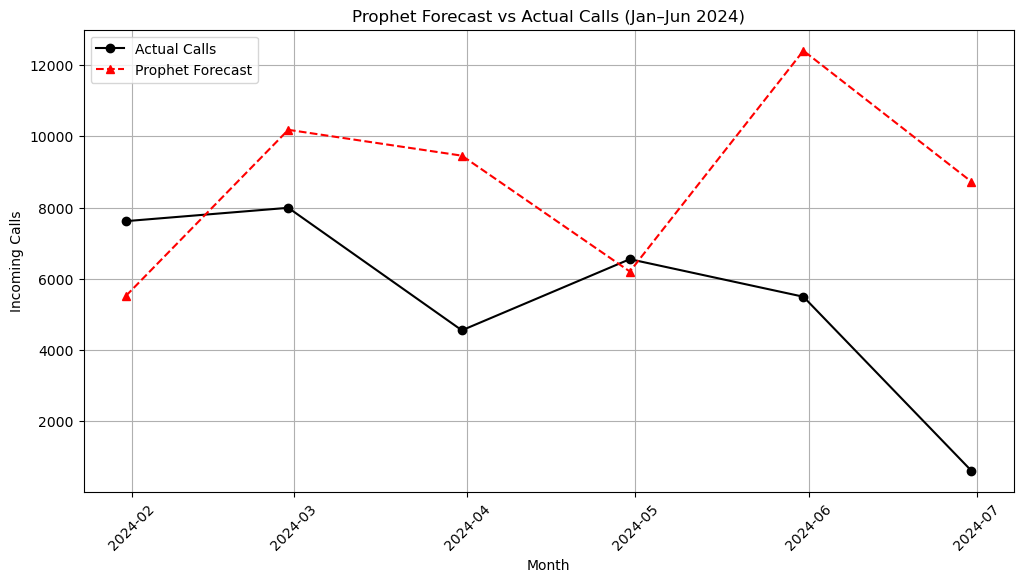

In [145]:
# Dates for test period
dates = test['ds']

plt.figure(figsize=(12,6))

# Actual calls
plt.plot(dates, y_true, label='Actual Calls', marker='o', color='black')

# Prophet forecast
plt.plot(dates, y_pred, label='Prophet Forecast', marker='^', linestyle='--', color='red')

# Optional: you can also plot the full forecast (train + future) if needed
# plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Full Forecast', color='orange', alpha=0.5)

plt.title('Prophet Forecast vs Actual Calls (Jan–Jun 2024)')
plt.xlabel('Month')
plt.ylabel('Incoming Calls')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

In [146]:
#The moving average outperformed ARIMA/SARIMA/Prophet on RMSE because the evaluation period 
#is short and the series is relatively stable. 
#Complex models may overfit short-term noise, while a simple average captures the central tendency effectively. 
#However, for longer-term forecasting and capturing seasonality or trend, SARIMA or Prophet would be more appropriate

Machine learning Models

In [147]:
#IN the next 2 cells we prepare data for forecast

In [148]:
# Create lag features
df_ml = df_monthly.copy()
df_ml['lag_1'] = df_ml['Incoming Calls'].shift(1)
df_ml['lag_2'] = df_ml['Incoming Calls'].shift(2)
df_ml['lag_3'] = df_ml['Incoming Calls'].shift(3)

# Optional: rolling mean
df_ml['rolling_mean_3'] = df_ml['Incoming Calls'].shift(1).rolling(window=3).mean()

# Month as categorical feature
df_ml['month'] = df_ml.index.month

# Drop NaNs created by lag
df_ml = df_ml.dropna()

In [149]:
train = df_ml.loc[:'2023-12']
test  = df_ml.loc['2024-01':'2024-06']

X_train = train[['lag_1','lag_2','lag_3','rolling_mean_3','month']]
y_train = train['Incoming Calls']

X_test = test[['lag_1','lag_2','lag_3','rolling_mean_3','month']]
y_test = test['Incoming Calls']



In [150]:
#Forecast using Random Forest


rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print("Random Forest RMSE:", rmse_rf)


Random Forest RMSE: 2947.210674869828


In [151]:
#Forecast using XGBoost

xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print("XGBoost RMSE:", rmse_xgb)

XGBoost RMSE: 2203.5085640836637


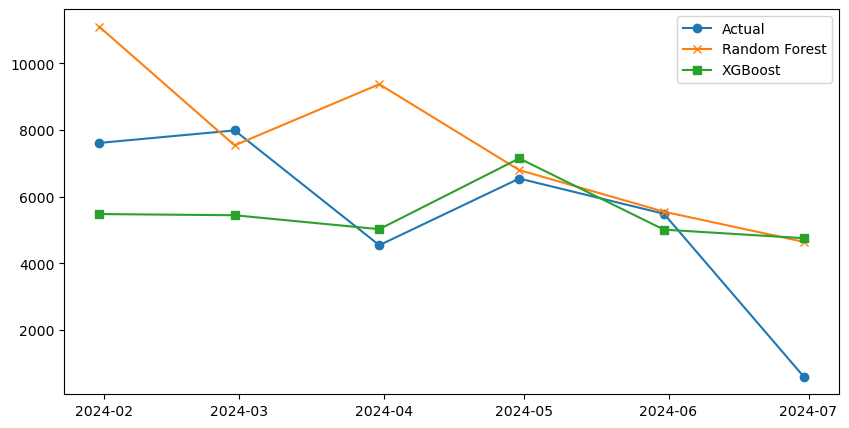

In [152]:
#Visual Comparision of variations of ML forecasting
plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test, label='Actual', marker='o')
plt.plot(y_test.index, y_pred_rf, label='Random Forest', marker='x')
plt.plot(y_test.index, y_pred_xgb, label='XGBoost', marker='s')
plt.legend()
plt.show()

In [ ]:
#Among ML Models XGboost gives best result